In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

##### Ajustando variáveis one-hot-encoding para string

In [4]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [5]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [6]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [7]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [8]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo da Random Forest

In [9]:
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=df_train.shape[1]
)

In [10]:
model.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=10, max_features=35, n_estimators=10)

##### Avaliando o modelo

In [11]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Accuracy no conjunto de Validação: {accuracy_val:.4f}')

Accuracy no conjunto de Validação: 0.9467


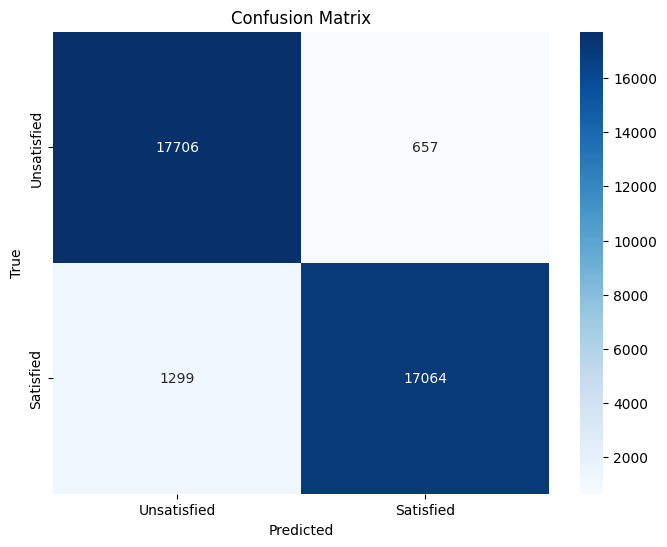

In [13]:
plot_confusion_matrix(y_pred=y_pred_val, y_test=y_val)

In [14]:
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy no conjunto de Teste: {accuracy_test:.4f}')

Accuracy no conjunto de Teste: 0.9545


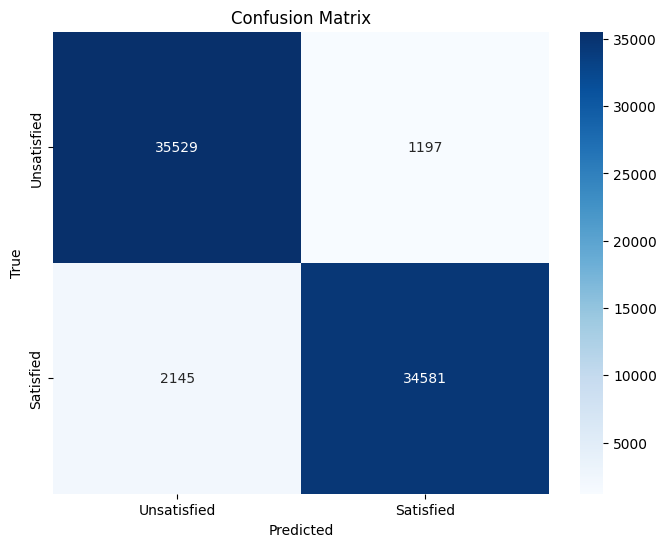

In [15]:
plot_confusion_matrix(y_pred=y_pred_test, y_test=y_test)